## 1) Library & Data Import

In [144]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import warnings
#warnings.filterwarnings("ignore")

In [145]:
df = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/tripadviser_review.csv")

In [146]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


#### Feature Description
- rating : 이용자 리뷰의 평가 점수
- text : 이용자 리뷰 평가 내용

-----

## 2) 데이터셋 살펴보기

### 2-1) 기본 정보 탐색

##### 데이터셋 기본 정보 탐색

In [147]:
df.shape

(1001, 2)

In [148]:
df.isnull().sum()

rating    0
text      0
dtype: int64

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  1001 non-null   int64 
 1   text    1001 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [150]:
print(df['text'][0])
print(df['text'][100])

여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다.
올 봄에 벚꽃기간에 방문, 협재를 바라보는 바다뷰가 좋고 대로변이라 렌트해서 가기도 좋음. 조식은 이용안했는데 근처 옹포밥집까지 아침 산책겸 걸어가서 하고옴. 루프탑 수영장과 바가 있었는데 내가 갔을때는 밤에 비바람이 너무 불어서 이용못하고옴 ㅠㅠ  단점으로는 모 유명 여행블로거 리뷰처럼 화장실 물떄가... 그거빼곤 다 만족


In [151]:
len(df['text'].values.sum()) #22만 글자

223576

-----

## 3) 한국어 텍스트 데이터 전처리

### 3-0) konlpy 설치

In [152]:
# konlpy 0.5.2의 JVM 버그로 인해, 0.5.1 버전으로 install
!pip install konlpy==0.5.1 jpype1 Jpype1-py3

### 3-1) 정규표현식 적용

In [153]:
import re

In [154]:
def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)
    return result

In [155]:
apply_regular_expression(df['text'][1])

'일 이상 연박시 침대 이불 베게등 침구류 교체 및 어메니티 보강이 필요해 보입니다 베스트 웨스턴 회원의 경우 객실 뷰와 층수 요청에 적극적으로 반영해 주시길 바랍니다'

-----

### 3-2) 한국어 형태소분석 - 명사 단위

##### 명사 형태소 추출

In [156]:
from konlpy.tag import Okt
from collections import Counter

In [157]:
nouns = Okt().nouns(apply_regular_expression(df['text'][0]))#okt.nouns() 텍스트에서 명사만 뽑아낸다.
nouns

['여행', '집중', '휴식', '제공', '호텔', '위치', '선정', '또한', '청소', '청결', '상태']

In [158]:
nouns = Okt().nouns(apply_regular_expression(' '.join(df['text'].tolist()))) # ("-".join(["a", "b", "c"])) >>> a-b-c
Counter(nouns).most_common(10)

[('호텔', 803),
 ('수', 498),
 ('것', 436),
 ('방', 334),
 ('우리', 329),
 ('위치', 328),
 ('곳', 321),
 ('공항', 307),
 ('이', 268),
 ('직원', 267)]

##### 한글자 명사 제거

In [159]:
Counter({x : Counter(nouns)[x] for x in Counter(nouns) if len(x) > 1}).most_common(10)
#nouns = [x for x in nouns if len(x) > 1]
#Counter(nouns).most_common(10)

[('호텔', 803),
 ('우리', 329),
 ('위치', 328),
 ('공항', 307),
 ('직원', 267),
 ('매우', 265),
 ('가격', 245),
 ('객실', 244),
 ('시설', 215),
 ('제주', 189)]

-----

### 3-3) 불용어 사전

In [160]:
stopwords = pd.read_csv('https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt').values.tolist()
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [161]:
jeju_list = ['제주', '제주도', '호텔', '리뷰', '숙소', '여행', '트립']
for i in jeju_list:
    stopwords.append(i)

-----

### 3-4) Word Count

##### BoW 벡터 생성

In [162]:
from sklearn.feature_extraction.text import CountVectorizer

In [163]:
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)
    nouns = Okt().nouns(result)
    nouns = [x for x in nouns if len(x) > 1]
    nouns = [x for x in nouns if x not in stopwords]
    return nouns

In [164]:
vect = CountVectorizer(tokenizer= lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df['text'].tolist())
word_list = vect.get_feature_names()
count_list =bow_vect.toarray().sum(axis = 0)
word_count_dict = dict(zip(word_list, count_list))


In [165]:
bow_vect.shape

(1001, 3599)

In [166]:
str(word_count_dict)[:100]

"{'가가': 4, '가게': 8, '가격': 245, '가격표': 1, '가구': 8, '가급': 1, '가기': 20, '가까이': 20, '가끔': 5, '가능': 10, '가"

-----

### 3-5) TF-IDF 적용

##### TF-IDF 변환

In [167]:
from sklearn.feature_extraction.text import TfidfTransformer

In [168]:
tfidf_vector = TfidfTransformer().fit_transform(bow_vect)

In [169]:
print(tfidf_vector[0])

  (0, 3588)	0.35673213299026796
  (0, 2927)	0.2582351368959594
  (0, 2925)	0.320251680858207
  (0, 2866)	0.48843555212083145
  (0, 2696)	0.23004450213863206
  (0, 2311)	0.15421663035331626
  (0, 1584)	0.48843555212083145
  (0, 1527)	0.2928089229786031
  (0, 790)	0.2528176728459411


##### 벡터 : 단어 맵핑

In [170]:
invert_index_vectorizer = {k:v for v, k in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:50])

{2866: '집중', 3588: '휴식', 2696: '제공', 2311: '위치', 1


-----

## 4) Logistic Regression 분류

### 4-1) 데이터셋 생성

##### Rating 데이터 이진으로 변환

In [171]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


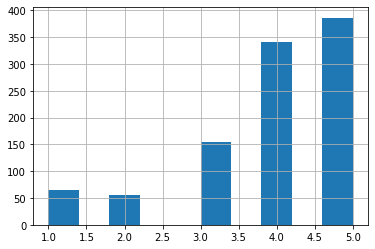

In [172]:
df.rating.hist()

In [173]:
df.sample(25).head()

,rating,text
353,5,협제해변인근에 부동산 문제로 제주에 갑자기 가게되었다. 혼자이고 조용히 하루 보내고...
635,5,직장에서 장기근속휴가를 받아 9월 17일부터 23일까지 일주일간 도미토리에서 머물렀...
110,4,"공항과 정말 가까워요, 차로 20분 이내 도착한 것 같아요. 전반적인 서비스는 나쁘..."
495,4,"호텔 (협상을) 가격도 저렴했고, 아주 깨끗하고, 편리하게 서부 제주 관광명소 (해..."
891,5,"시내와 위치가 조금 멀기는 하지만, 우선 방이 넓직해서 너무 좋습니다. 골프텔도 조..."


In [174]:
def rating_to_label(rating):
    if rating > 3 :
        return 1
    else :
        return 0

In [175]:
df['y'] = df.apply(lambda x : rating_to_label(x['rating']), axis=1)
df.head()

,rating,text,y
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...,1
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입...",1
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...,1
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...,1
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...,1


In [176]:
df['y'].value_counts()

1    726
0    275
Name: y, dtype: int64

-----

### 4-2) 데이터셋 분리

In [177]:
from sklearn.model_selection import train_test_split

In [179]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_vector, df['y'], test_size = 0.3)

In [180]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((700, 3599), (301, 3599), (700,), (301,))

-----

### 4-3) 모델 학습

##### Logistic Regression 학습

In [181]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [182]:
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
pred = lr.predict(x_test)

##### 분류 결과 평가

In [183]:
accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred)

(0.7774086378737541,
 0.7762711864406779,
 0.9956521739130435,
 0.8723809523809524)

In [184]:
from sklearn.metrics import confusion_matrix

In [185]:
confmat = confusion_matrix(y_test, pred)
confmat

array([[  5,  66],
       [  1, 229]])

-----

### 4-4) 샘플링 재조정

##### 1:1 Sampling

In [187]:
pos_ran_idx = df[df['y']==1].sample(275, random_state = 33).index.tolist()
neg_ran_idx = df[df['y']==0].sample(275, random_state = 33).index.tolist()
ran_idx = pos_ran_idx + neg_ran_idx

In [194]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_vector[ran_idx], df['y'][ran_idx], test_size = 0.3)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((385, 3599), (165, 3599), (385,), (165,))

##### 모델 재학습

In [195]:
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
pred = lr.predict(x_test)

##### 분류 결과 평가

In [196]:
accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred)

(0.7575757575757576,
 0.7530864197530864,
 0.7530864197530864,
 0.7530864197530863)

In [197]:
confmat = confusion_matrix(y_test, pred)
confmat

array([[64, 20],
       [20, 61]])

-----

## 5) 긍정/부정 키워드 분석

##### Logistic Regression 모델의 coef 분석

<BarContainer object of 3599 artists>

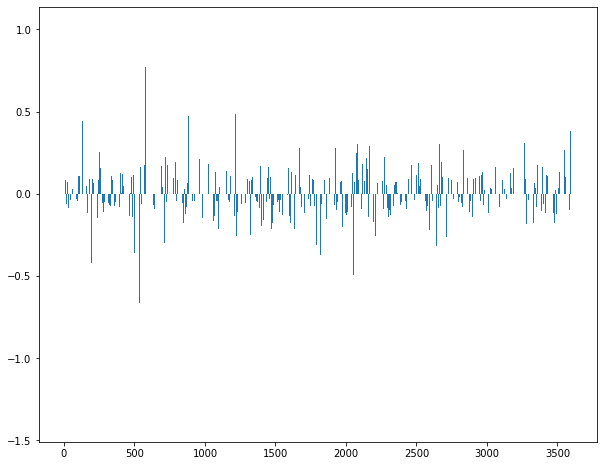

In [207]:
plt.rcParams['figure.figsize'] = [10,8] # ==>  plt.figure(figsize =) 기본값설정
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

##### 긍정/부정 키워드 출력

In [218]:
coef_pos_idx = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_nge_idx = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=False)
coef_pos_idx[:5], coef_nge_idx[-5:]

([(1.0163750411503911, 2957),
  (0.9877584108993003, 2977),
  (0.8587836361270976, 2400),
  (0.8115451833764038, 385),
  (0.7731131404826025, 578)],
 [(0.7731131404826025, 578),
  (0.8115451833764038, 385),
  (0.8587836361270976, 2400),
  (0.9877584108993003, 2977),
  (1.0163750411503911, 2957)])

In [213]:
for coef in coef_pos_idx[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])#invert_index_vectorizer는 dict기 때문에 ()가 아닌 []

최고 1.0163750411503911
추천 0.9877584108993003
이용 0.8587836361270976
근처 0.8115451833764038
다음 0.7731131404826025
분위기 0.7488557299006078
버스 0.7001726044606007
바로 0.6872574713801908
게스트하우스 0.681689614796062
조식 0.6695051565733594
시설 0.6608195653756167
가격 0.6512694475615469
건물 0.6015380754759769
신축 0.6005253580146517
주차 0.5857837273253509


In [219]:
for coef in coef_nge_idx[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

냄새 -1.3880588863016874
별로 -1.1856250273663718
다른 -1.051830044925879
화장실 -0.8294161257596194
사람 -0.8173680751437219
노후 -0.6635263365176071
그냥 -0.6549702339232998
느낌 -0.6242134988804832
최악 -0.6053122100729157
소음 -0.5581232401363252
상태 -0.5575655677227772
모텔 -0.5440417609624422
수건 -0.5346048932095403
곰팡이 -0.5248918401754419
라면 -0.5232978675867311
